# Introduction:
This section focuses on EDA and feature engineering for categorical columns. 

For previous work access following link
1. Data cleaning : https://www.kaggle.com/lajari/sec1-tedious-data-cleaning
2. EDA and Feature engineering for numerical features :https://www.kaggle.com/lajari/sec2-eda-feature-engineering

We have observed around 43 categorical columns in given datset. Our study highlights, which features have significant information to predict our target column. Basically we are filtering out less significant column and test final data (including numerical and categorical features) on simple regressor.

Note: The data generated from previous section will be used for analysis. 


## Load Data

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train =pd.read_csv('/kaggle/input/sec2-eda-feature-engineering/engineered_train.csv')
test =pd.read_csv('/kaggle/input/sec2-eda-feature-engineering/engineered_test.csv')
traintest = pd.concat([train,test], axis = 0,ignore_index = False)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,RoomSize,LotPerimeter,YrMoSold,Age,IsRemod,TotFinBsmt,IsBsmt,TotFullBath,TotHalfBath,TotPorch
0,1.0,60.0,RL,65.0,8450.0,Pave,NAv,Reg,Lvl,AllPub,...,213.750000,390.000000,2008.02,5.02,0,706.0,1,3.0,1.0,61.0
1,2.0,20.0,RL,80.0,9600.0,Pave,NAv,Reg,Lvl,AllPub,...,210.333333,400.000000,2007.05,31.05,0,978.0,1,2.0,1.0,0.0
2,3.0,60.0,RL,68.0,11250.0,Pave,NAv,IR1,Lvl,AllPub,...,297.666667,466.882353,2008.09,7.09,1,486.0,1,3.0,1.0,42.0
3,4.0,70.0,RL,60.0,9550.0,Pave,NAv,IR1,Lvl,AllPub,...,245.285714,438.333333,2006.02,91.02,1,216.0,1,2.0,0.0,307.0
4,5.0,60.0,RL,84.0,14260.0,Pave,NAv,IR1,Lvl,AllPub,...,244.222222,507.523810,2008.12,8.12,0,655.0,1,3.0,1.0,84.0


## EDA

In [3]:
catcols = train.select_dtypes(include=np.object).columns
print('Number of categorical columns:',len(catcols))

Number of categorical columns: 43


In [4]:
def generate_plots(r,c,columns):
    """
    Generate pair of boxplot and countplot for each column in columns each row contains two such pairs'
    
    """
    fig ,axs = plt.subplots(r,c,figsize=(20,40))

    axs = axs.flatten()
    i = 0
    for col in columns:
        
        sns.boxplot(x=train[col],y=train['LogPrice'],ax=axs[i])
        sns.countplot(train[col], ax=axs[i+1])
        
        if train[col].nunique()>6:
            axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
            axs[i+1].set_xticklabels(axs[i+1].get_xticklabels(), rotation=45) 
            
        i=i+2
        plt.tight_layout()
    

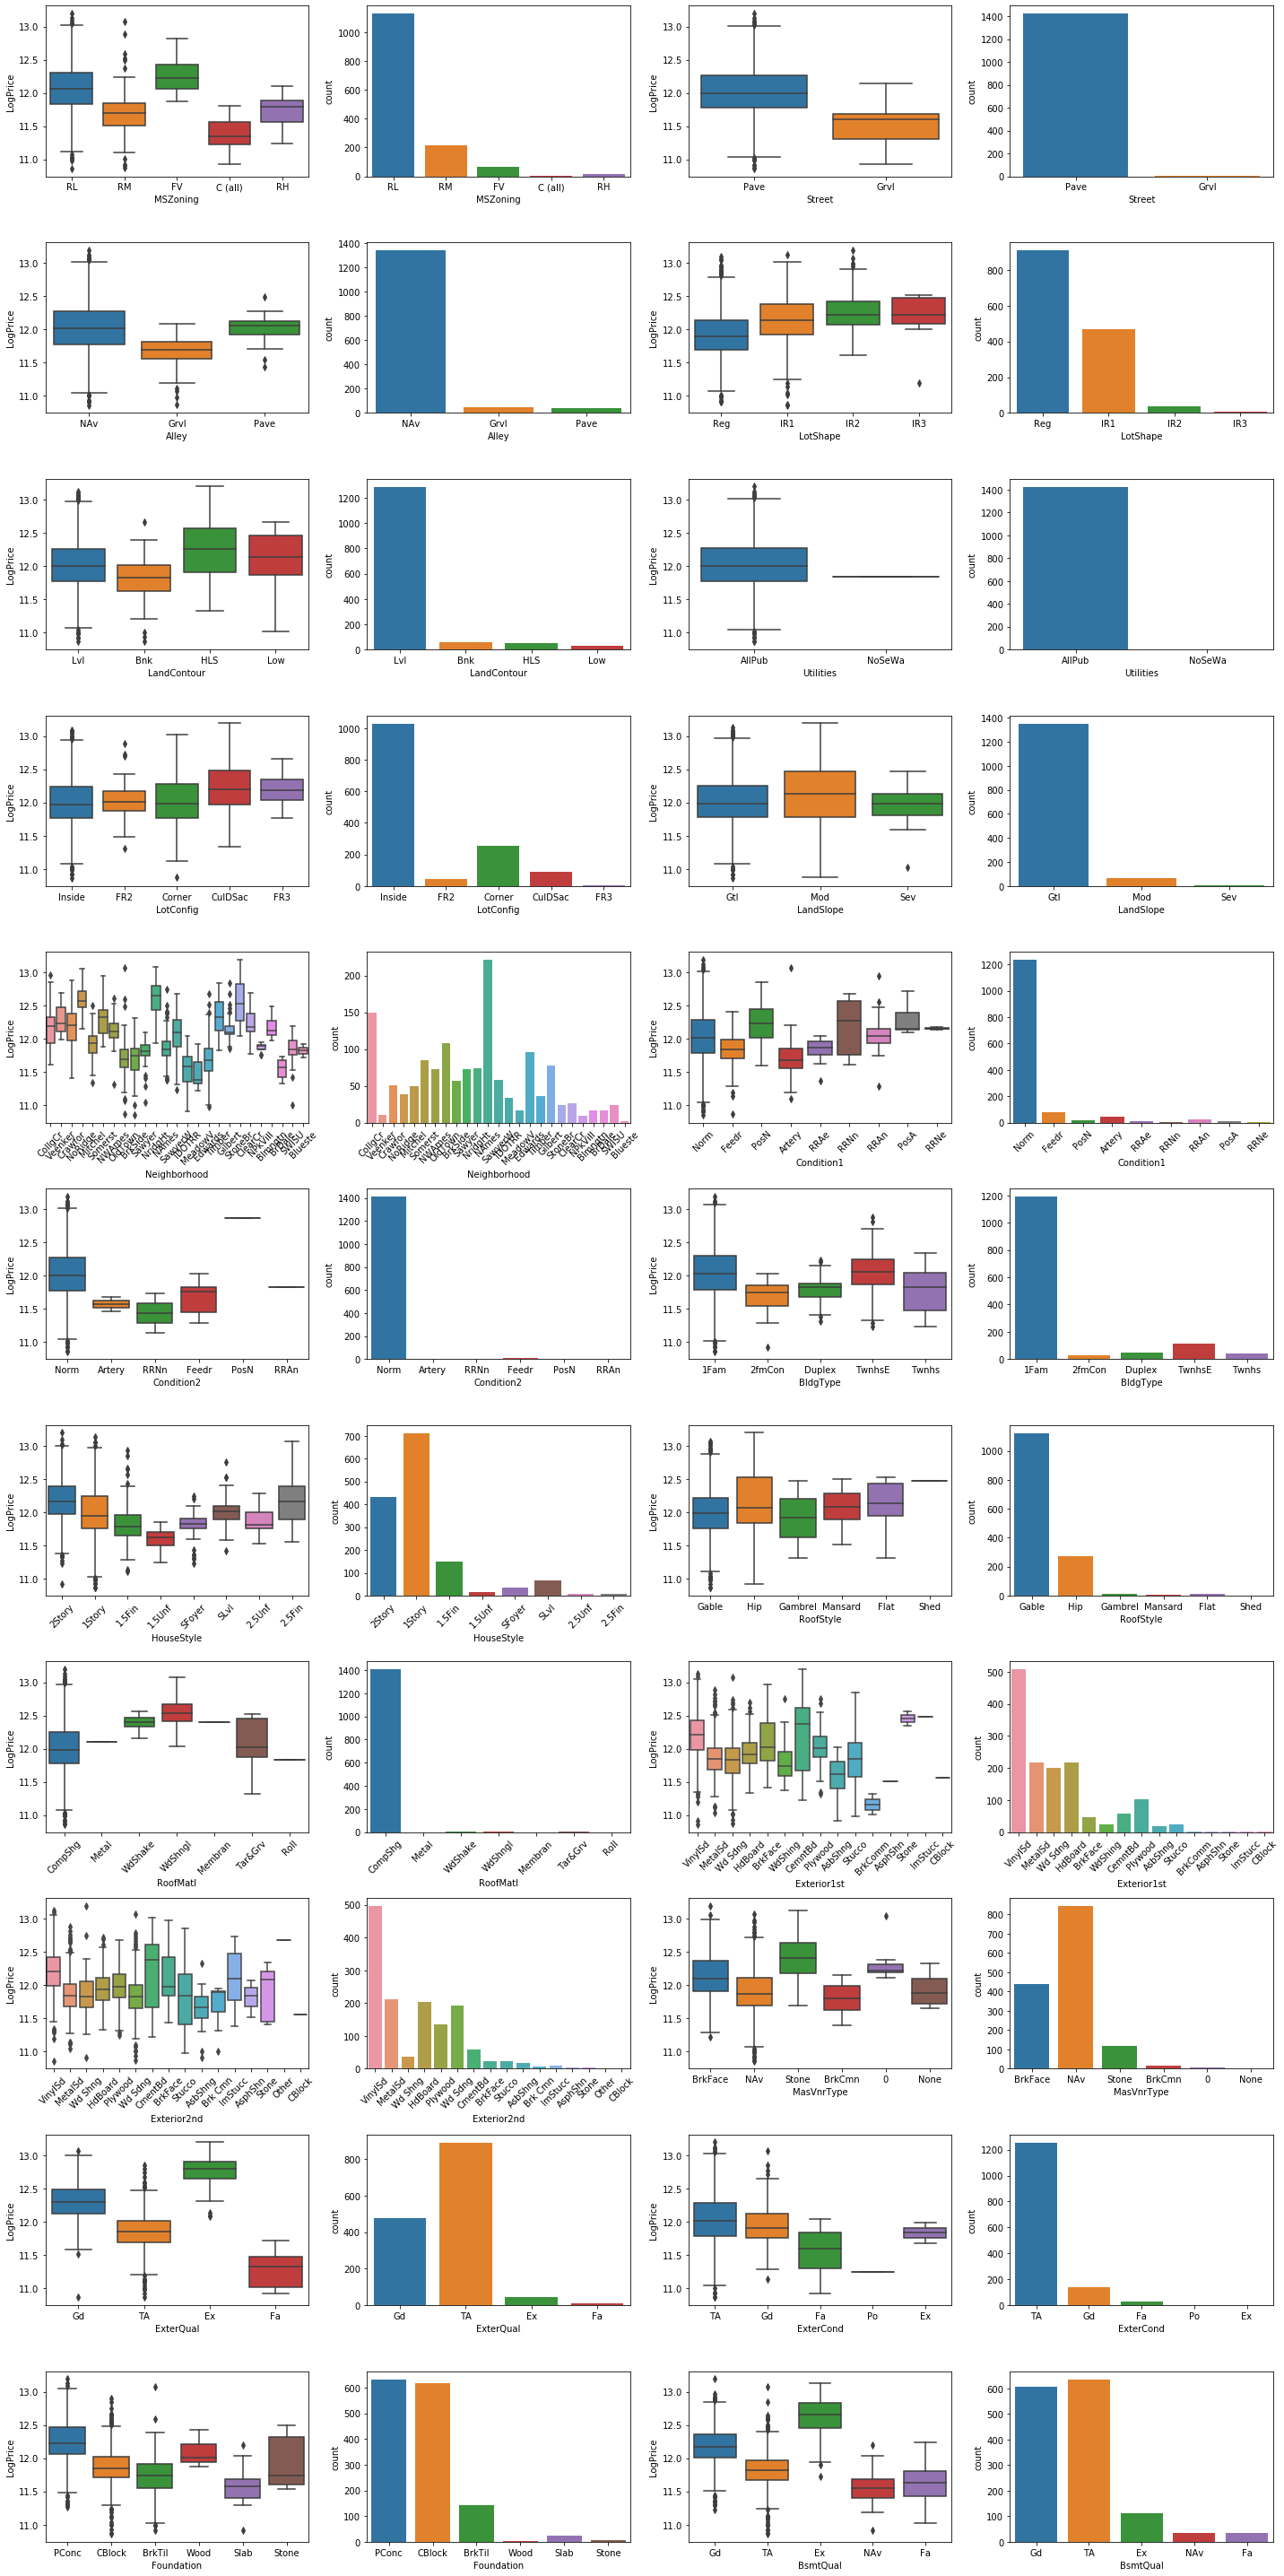

In [5]:
generate_plots(11,4,catcols[:22])

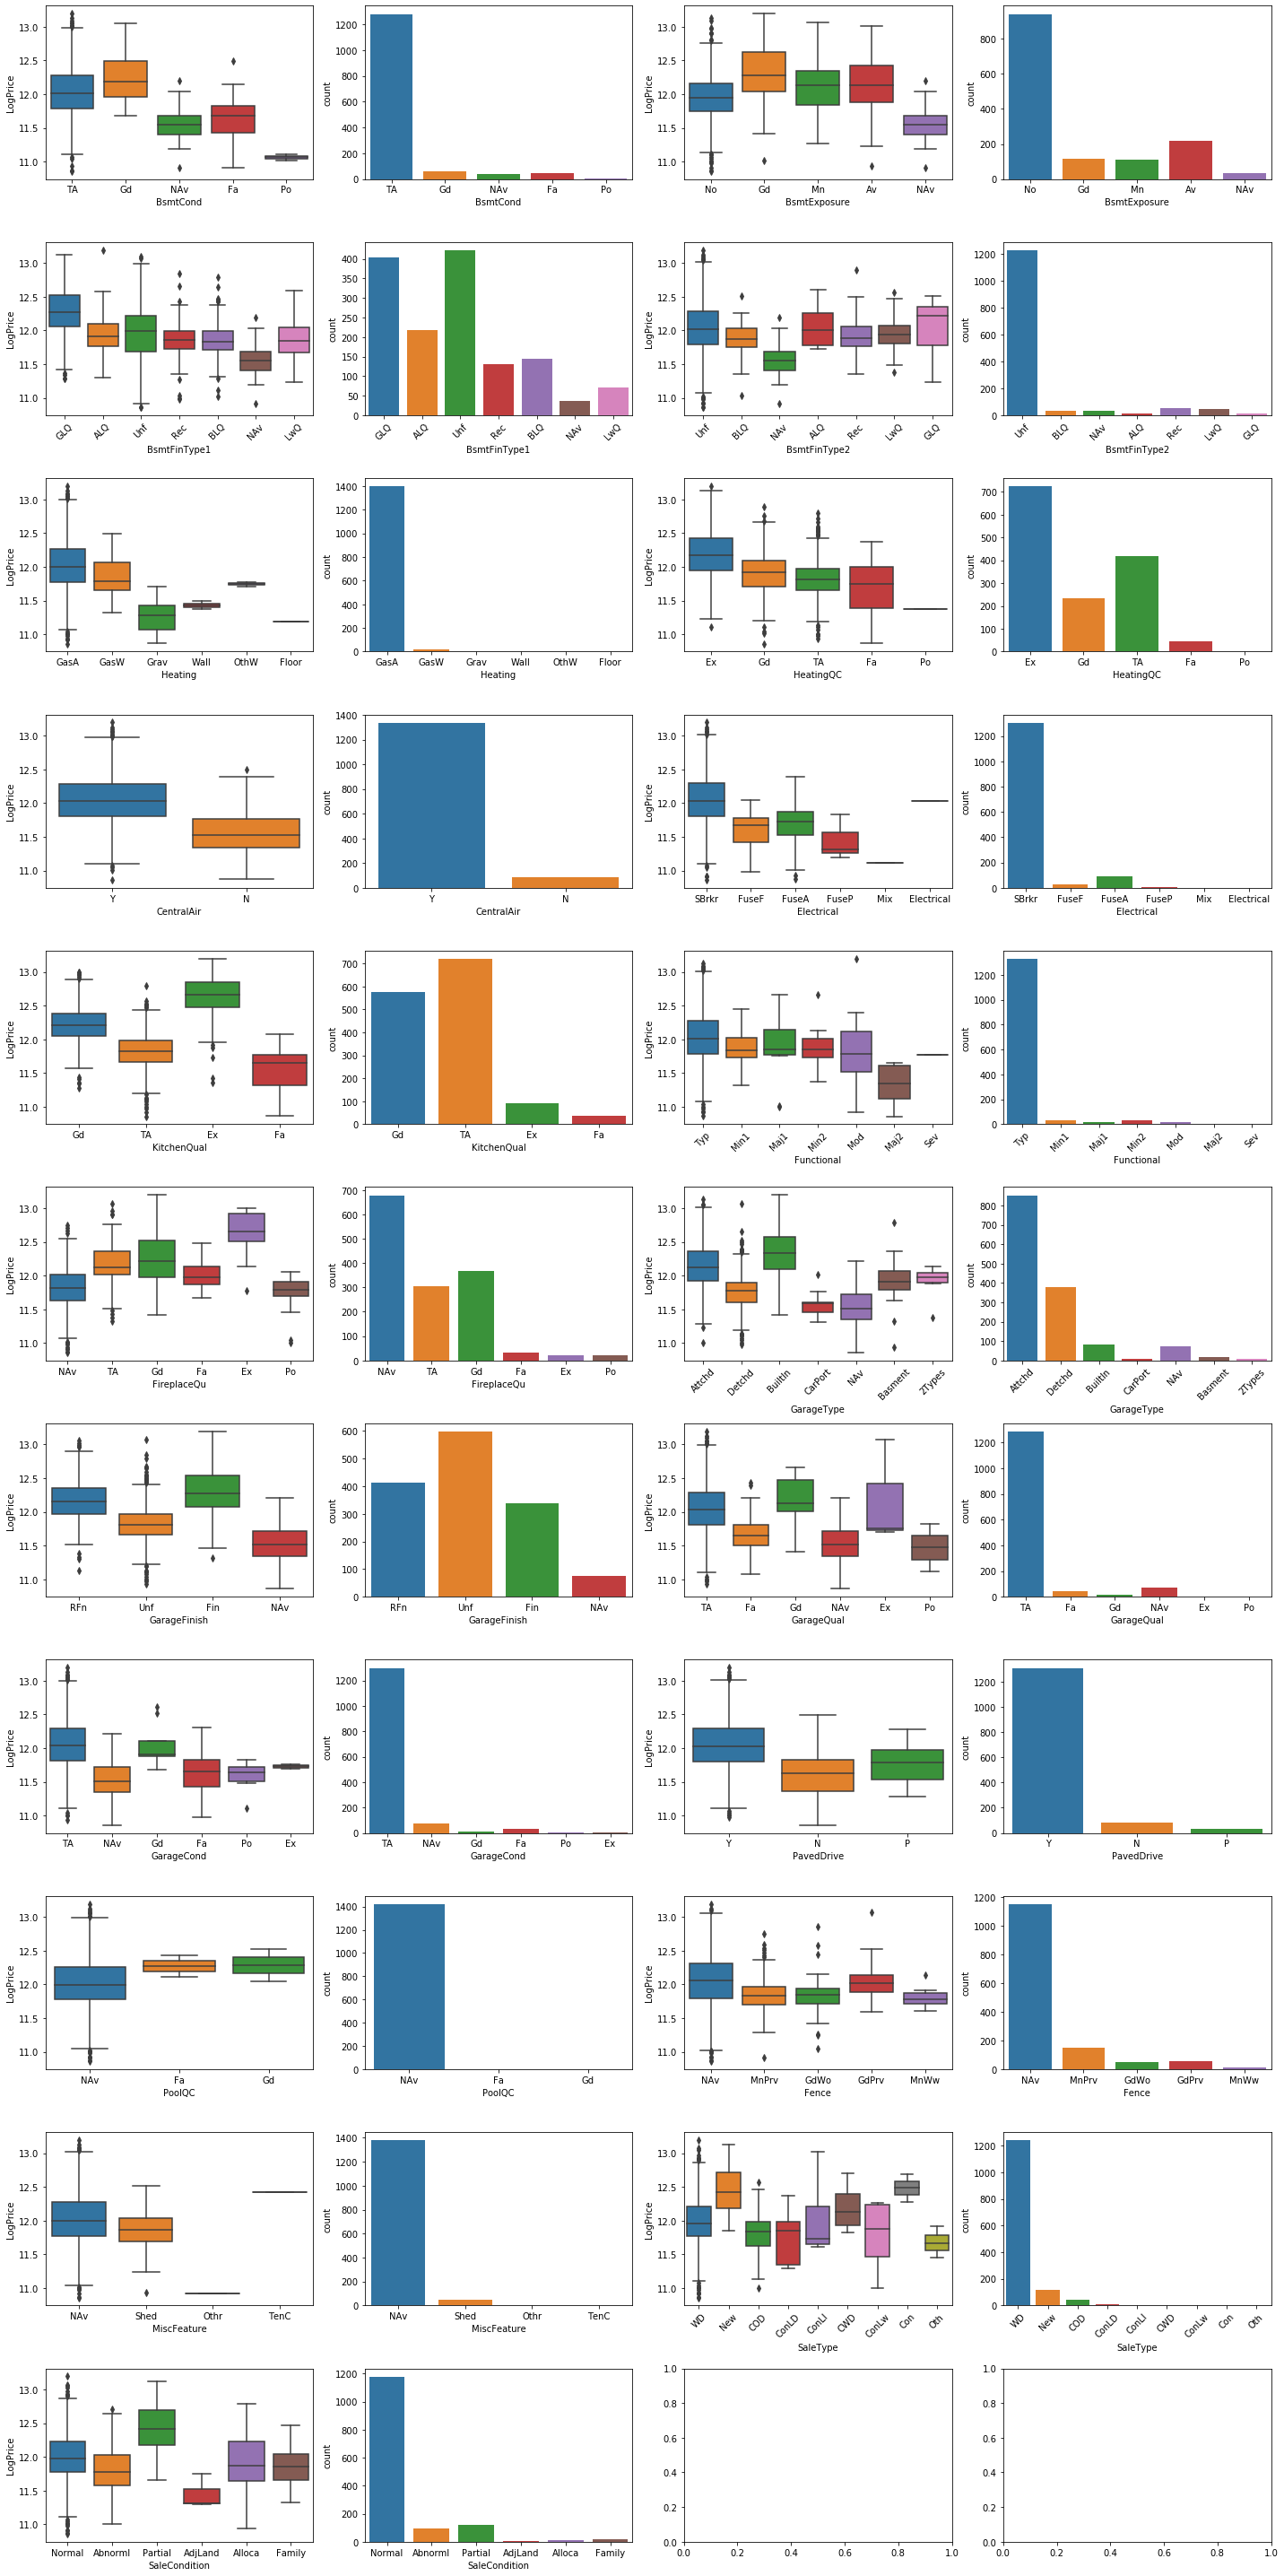

In [6]:
generate_plots(11,4,catcols[22:])

In above plots we have observed two import things. First, there are some set of features which has most of the data from same group. Second,some set of features whose median of groups are quite same. In next section we will remove such features as they do not provide significant information for prediction.

## Analysis of Frequency Ditribution:

We are aiming to remove the columns with low variability. Here, low variability implies the feature which has more than 95% of total rows contain same value. 

In [7]:
low_var_cols = []
for col in catcols:
    freq_db = (traintest[col].value_counts(normalize = True))      # We will analyse for whole dataset (include train and test)
    if freq_db[freq_db>0.95].sum() != 0:
        low_var_cols.append(col)
low_var_cols
    

['Street',
 'Utilities',
 'LandSlope',
 'Condition2',
 'RoofMatl',
 'Heating',
 'PoolQC',
 'MiscFeature']

## ANOVA Test:

ANOVA is called as analysis of Variance. It is used to compare the means of different groups. In this section, we are performing one way ANOVA. It means analysis will contain one feature at a time. and we are trying to analyse the differences in means of various groups (here groups refers to levels in categorical columns). 

ANOVA Hypothesis:

    Null hypotheses: Groups means are equal (no variation in means of groups)
    Alternative hypotheses: At least, one group mean is different from other groups

If P-value obtained from ANOVA analysis is less than 0.05, then we conclude that there are significant difference among groups. In following code block we will filter out the columns which fails to reject null hypothesis.

In [8]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

const_mean_across_grp = []

print('Columns | P-value\n','-'*30)

for col in catcols:
    mod = ols('LogPrice ~ '+col ,data=train).fit()
    anova_table = sm.stats.anova_lm(mod,typ=2)
    
    pr  = anova_table.loc[col,'PR(>F)']
   
    if pr > 0.05:
        print(col,'|',pr)
        const_mean_across_grp.append(col)


Columns | P-value
 ------------------------------
Utilities | 0.6211695404917266
LandSlope | 0.2082195860647517
PoolQC | 0.3947771097829451


We are going to remove above columns as their P-value >0.05. It means these features group means are not significantly differ.

## Dropping less important columns:
We will drop columns listed in 'low_var_cols' and 'const_mean_across_grp' from train and test dataset and create final dataset for our modelling

In [9]:
s1 = set(const_mean_across_grp)
s2 = set(low_var_cols)
dropcols = list(s1.union(s2))

train.drop(dropcols,axis = 1,inplace=True)
test.drop(dropcols,axis = 1,inplace = True)


## Test Model:

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# one hot encoding for categoricals
cats = list(train.select_dtypes(object).columns)
all_X = pd.get_dummies(data = train,columns = cats,sparse = True).copy()
all_X.drop(['LogPrice','SalePrice','Id'],axis =1, inplace=True)
all_y = train['LogPrice']

# Modelling and validating simple regressor
scores =cross_val_score(LinearRegression(),all_X,all_y, cv=3,scoring = 'neg_mean_squared_error')

# RMSE score
np.sqrt(-scores.mean())

2417.1925410494196

We obtained quite good result using simple model. Our next section about predictive modelling is coming soon. In that section, we will go through various traditional and advanced modelling approaches and find out the best model for our given problem.


In [11]:
train.to_csv('eng_filt_train.csv',index = False)
test.to_csv('eng_filt_test.csv',index = False)